# Case Study 3 - Email Spam

__Team Members:__ Amber Clark, Andrew Leppla, Jorge Olmos, Paritosh Rai

# Team Strategy

Emails are read in.  Kept: From, Subject, Body.
- Remove \n with regex
- Remove other non-alphabetic characters - keep the counts?

Feature Extraction:
1. Vectorization - TFIDF (removes stop words)
If we have time:
2. Created 'trusted' and 'spam' email address book to filter spam - IS THIS OUT OF SCOPE PER SCOPE?

Model:
Classification with Naive Bayes - Amber, Jorge
1. Subject Only = Baseline
2. Body (+Subject?)

Clustering:
kNN with cosine distance for NLP - Andrew, Paritosh

# Content
* [Business Understanding](#business-understanding)
    - [Scope](#scope)
    - [Introduction](#introduction)
    - [Methods](#methods)
    - [Results](#results)
* [Data Evaluation](#data-evaluation)
    - [Loading Data](#loading-data) 
    - [Data Summary](#data-summary)
    - [Missing Values](#missing-values)
    - [Feature Removal](#feature-removal)
    - [Exploratory Data Analysis (EDA)](#eda)
    - [Assumptions](#assumptions)
* [Model Preparations](#model-preparations)
    - [Sampling & Scaling Data](#sampling-scaling-data)
    - [Proposed Method](#proposed-metrics)
    - [Evaluation Metrics](#evaluation-metrics)
    - [Feature Selection](#feature-selection)
* [Model Building & Evaluations](#model-building)
    - [Sampling Methodology](#sampling-methodology)
    - [Model](#model)
    - [Performance Analysis](#performance-analysis)
* [Model Interpretability & Explainability](#model-explanation)
    - [Examining Feature Importance](#examining-feature-importance)
* [Conclusion](#conclusion)
    - [Final Model Proposal](#final-model-proposal)
    - [Future Considerations and Model Enhancements](#model-enhancements)
    - [Alternative Modeling Approaches](#alternative-modeling-approaches)

# Business Understanding & Executive Summary <a id='business-understanding'/>

What are we trying to solve for and why is it important?


### Scope <a id='scope'/>


### Introduction <a id='introduction'/>


### Methods <a id='methods'/>
 
 
### Results <a id='results'/>
 

# Data Evaluation <a id='data-evaluation'>
    

Summarize data being used?

Are there missing values?

Which variables are needed and which are not?

What assumptions or conclusions are you drawing about your data?

In [105]:
# standard libraries
import pandas as pd
import numpy as np
import re
import os
from IPython.display import Image

# email
#from email.message import EmailMessage
from email import policy
from email.parser import BytesParser

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from tabulate import tabulate

# data pre-processing
from sklearn.model_selection import train_test_split

# prediction models


# import warnings filter
'''import warnings
warnings.filterwarnings('ignore')
from warnings import simplefilter 
simplefilter(action='ignore', category=FutureWarning)'''

"import warnings\nwarnings.filterwarnings('ignore')\nfrom warnings import simplefilter \nsimplefilter(action='ignore', category=FutureWarning)"

## Loading Data <a id='loading-data'>

In [106]:
%%javascript
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [107]:
nb_name

'case_study3_template.ipynb'

In [108]:
import os
notebook_path = os.path.abspath(nb_name)

In [109]:
notebook_path

'/Users/Amber/Documents/SMU/QTW/QTW-SPRING-2022/ds7333_case_study_3/case_study3_template.ipynb'

In [110]:
file_spam = os.path.join(os.path.dirname(notebook_path), "SpamAssassinMessages")

In [111]:
file_spam

'/Users/Amber/Documents/SMU/QTW/QTW-SPRING-2022/ds7333_case_study_3/SpamAssassinMessages'

In [112]:
def get_all_files(folder):
    file_list = []
    if os.path.exists(folder):
        for root, dirs, files in os.walk(folder):
            for file in files:
                file_list.append(os.path.join(root,file))
    return file_list

In [113]:
folders = os.listdir(file_spam)
folders

['spam', 'hard_ham', 'spam_2', 'easy_ham', 'easy_ham_2']

In [114]:
# Get the file names in each folder (list of lists)
files = [ os.listdir(file_spam+ '/'+ folder) for folder in folders] 

# Create a list of dataframes for all of the folders
emails = [ pd.DataFrame({'folder' : [], 'from' : [], 'subject' : [], 'body': []}) ]*len(folders)

# Add folder path to file names
for i in range(0,len(folders)):
    for j in range(0, len(files[i])):
        files[i][j] = str(file_spam +'/' + folders[i] + '/' + files[i][j]) 
        
        # Parse and extract email 'subject' and 'from'
        with open(files[i][j], 'rb') as fp:
            msg = BytesParser(policy=policy.default).parse(fp)
            
            # Error checking when reading in body for some html-based emails from spam folders
            try:
                simplest = msg.get_body(preferencelist=('plain', 'html'))
                try:
                    new_row = {'folder': folders[i], 'from': msg['from'], 'subject': msg['subject'], 'body': simplest.get_content()}
                    emails[i] = emails[i].append(new_row, ignore_index=True)
                except:
                    new_row = {'folder': folders[i], 'from': msg['from'], 'subject':msg['subject'], 'body':'Error(html)'}
                    emails[i] = emails[i].append(new_row, ignore_index=True)
            except:
                new_row = {'folder': folders[i], 'from': msg['from'], 'subject':msg['subject'], 'body':'Error(html)'}
                emails[i] = emails[i].append(new_row, ignore_index=True)

In [115]:
# Emails per folder
print("# files in folders:", [len(i) for i in files])
print("# emails read in  :", [i.shape[0] for i in emails])

# Total emails
print( "\n# total emails =", sum([len(i) for i in files]) )

# files in folders: [1001, 501, 1398, 5052, 1401]
# emails read in  : [1001, 501, 1398, 5052, 1401]

# total emails = 9353


In [116]:
# Create single dataframe from all folders
df = pd.concat( [emails[i] for i in range(0, len(emails))], axis=0)

#  Keep the indices from the folders
df = df.reset_index() 

# create response column from folder names
spam = [(i=='spam' or i=='spam_2') for i in df['folder']]
df = pd.concat([df, pd.Series(spam).astype(int)], axis=1)

df.columns = ['folder_idx', 'folder', 'from', 'subject', 'body','spam']

df.shape

(9353, 6)

In [117]:
df.head()

,folder_idx,folder,from,subject,body,spam
0,0,spam,pamela4701@eudoramail.com,Let us find the right mortgage lender for you ...,"Dear Homeowner,\n \nInterest Rates are at thei...",1
1,1,spam,CopyYourDVD <atomica2020@hotmail.com>,"Friend, Copy ANY DVD or Playstation Game with ...","Friend,Now you can copy DVD's and Games\nhttp:...",1
2,2,spam,IQ - Safe Harbor <sh@insiq.us>,5% Guaranteed for Eight Years,Pocket the newest 8 year annuity!\t Pocket th...,1
3,3,spam,Customer Service <greatoffers@sendgreatoffers....,Congratulations! You Get a Free Handheld Organ...,<html><head>\n<title>Congratulations! You Get ...,1
4,4,spam,don <apf@wu-wien.ac.at>,PROTECT YOUR INFORMATION AND YOUR COMPUTER,ATTENTION: This is a MUST for ALL Computer Use...,1


In [118]:
df['spam'].value_counts()

0    6954
1    2399
Name: spam, dtype: int64

In [119]:
CLEANR = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
def cleanhtml(raw_html):
    cleantext = re.sub(CLEANR, '', raw_html)
    return cleantext

In [120]:
def cleanAndSplit(raw_text): 
    temp = []
    for word in raw_text.split():
        temp.append(re.sub(r"[^a-zA-Z0-9]","",word).lower())
    return temp

In [121]:
def cleanBody(raw_content):
    clean_from_html = cleanhtml(raw_content)
    out = cleanAndSplit(clean_from_html)
    return out

In [122]:
df['clean_body'] = df['body'].apply(cleanBody)

In [123]:
df.head()

,folder_idx,folder,from,subject,body,spam,clean_body
0,0,spam,pamela4701@eudoramail.com,Let us find the right mortgage lender for you ...,"Dear Homeowner,\n \nInterest Rates are at thei...",1,"[dear, homeowner, interest, rates, are, at, th..."
1,1,spam,CopyYourDVD <atomica2020@hotmail.com>,"Friend, Copy ANY DVD or Playstation Game with ...","Friend,Now you can copy DVD's and Games\nhttp:...",1,"[friendnow, you, can, copy, dvds, and, games, ..."
2,2,spam,IQ - Safe Harbor <sh@insiq.us>,5% Guaranteed for Eight Years,Pocket the newest 8 year annuity!\t Pocket th...,1,"[pocket, the, newest, 8, year, annuity, pocket..."
3,3,spam,Customer Service <greatoffers@sendgreatoffers....,Congratulations! You Get a Free Handheld Organ...,<html><head>\n<title>Congratulations! You Get ...,1,"[congratulations, you, get, a, free, handheld,..."
4,4,spam,don <apf@wu-wien.ac.at>,PROTECT YOUR INFORMATION AND YOUR COMPUTER,ATTENTION: This is a MUST for ALL Computer Use...,1,"[attention, this, is, a, must, for, all, compu..."


In [124]:
df.isna().sum()

folder_idx     0
folder         0
from           5
subject       12
body           0
spam           0
clean_body     0
dtype: int64

## Data Summary <a id='data-summary'>

## Missing Values <a id='missing-values'>



In [125]:
# Rows where body couldn't be read in = 'Error(html)'
df.loc[df['body']=='Error(html)']

# All spam emails

,folder_idx,folder,from,subject,body,spam,clean_body
460,460,spam,Affordable Computer Supply <InkjetDeals@acsmsu...,Printer Cartridges as low as $1.21 each!,Error(html),1,[errorhtml]
522,522,spam,zzzz@netscape.net,Collect Your Money! Time:1:30:33 AM,Error(html),1,[errorhtml]
549,549,spam,eb@via.ecp.fr,"Over $100,000 Per Year Possible On The Net! N...",Error(html),1,[errorhtml]
793,793,spam,Affordable Computer Supply <InkjetDeals@acsmsu...,Printer Cartridges as low as $1.21 each!,Error(html),1,[errorhtml]
874,874,spam,"""Books@Books""@BlackRealityPublishing.com","Free Excerpt; Baby Makers, Loser Choosers, & ...",Error(html),1,[errorhtml]
905,905,spam,eb@via.ecp.fr,"Over $100,000 Per Year Possible On The Net! N...",Error(html),1,[errorhtml]
918,918,spam,"""Books@Books""@BlackRealityPublishing.com","Free Excerpt; Baby Makers, Loser Choosers, & ...",Error(html),1,[errorhtml]
949,949,spam,zzzz@netscape.net,Collect Your Money! Time:1:30:33 AM,Error(html),1,[errorhtml]
1523,21,spam_2,targetemailextractor@btamail.net.cn,"Direct Email Blaster, Email extractor, email d...",Error(html),1,[errorhtml]
1524,22,spam_2,iqsoftware@export2000.ro,[Avfs] Romanian Software Production & Export,Error(html),1,[errorhtml]


In [126]:
# Count of body read Errors
df.loc[df['body']=='Error(html)'].shape[0]

33

In [127]:
# Look at file example with Error(html)
with open(files[4][1], 'rb') as fp:
    msg = BytesParser(policy=policy.default).parse(fp)
print(msg)

Return-Path: <webmake-talk-admin@example.sourceforge.net>
Delivered-To: yyyy@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id E877243C36
	for <jm@localhost>; Tue, 20 Aug 2002 06:51:13 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for jm@localhost (single-drop); Tue, 20 Aug 2002 11:51:13 +0100 (IST)
Received: from usw-sf-list2.sourceforge.net (usw-sf-fw2.sourceforge.net
    [216.136.171.252]) by dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id
    g7K6a5Z27627 for <jm@jmason.org>; Tue, 20 Aug 2002 07:36:05 +0100
Received: from usw-sf-list1-b.sourceforge.net ([10.3.1.13]
    helo=usw-sf-list1.sourceforge.net) by usw-sf-list2.sourceforge.net with
    esmtp (Exim 3.31-VA-mm2 #1 (Debian)) id 17h2cW-00059K-00; Mon,
    19 Aug 2002 23:36:04 -0700
Received: from docserver.cac.washington.edu ([140.142.32.13]) by
    usw-sf-list1.sourceforge.net with esmtp (Cipher TLSv1:DES

## Feature Removal <a id='feature-removal'>

## Exploratory Data Analysis (EDA) <a id='eda'>

### 

### Feature Collinearity <a id='feature-collinearity'>


### Feature Outliers 
 

## Assumptions <a id='assumptions'>

# Model Preparations <a id='model-preparations'/>

What methods did you use (or not) to solve the problem?

Why are the methods you chose appropriate given the business objective?

How did you decide your approach was useful?  If more than one method, which one was better or why are each better or not?

What evaluation smetrics are most useful given the problem is a binary classification (ex. accuracy, f1-score, precision, recall AUC, etc)?



## Sampling & Scaling Data <a id='sampling-scaling-data' />

## Proposed Method <a id='proposed-metrics' />

## Evaluation Metrics <a id='evaluation-metrics' />

### Baseline Model

## Feature Selection <a id='feature-selection' />

# Model Building & Evaluations <a id='model-building'/>

Primary task is buiding a logistic regression to predict hospital readmittances.

How did you handle missing values?

Specify your sampling methodology

Set up your models - highlights of any important parameters

Analysis of your models performance

### Base Naive Bayes

Team drew inspriation from https://towardsdatascience.com/training-a-naive-bayes-model-to-identify-the-author-of-an-email-or-document-17dc85fa630a

In [128]:
from sklearn.naive_bayes import GaussianNB
from time import time

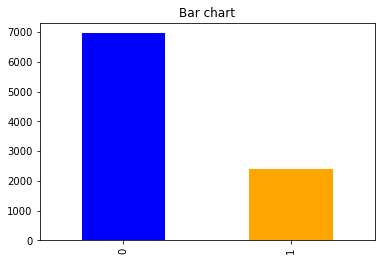

In [129]:
count_Class=pd.value_counts(df["spam"], sort= True)
count_Class.plot(kind= 'bar', color= ["blue", "orange"])
plt.title('Bar chart')
plt.show()

In [130]:
t0 = time()
model = GaussianNB()

In [131]:
pd.DataFrame(data=X.toarray(), columns=vocabulary).iloc[:,0::2]

,,00,0000,00000000,00000002,00001,000013118,000017848dde101aa985090474a91ec93fcf0,000017c7d6921e671bbe18ebb5f893cd9bb35,000025a587ae61666c5aa097c8e866aedcc59,...,zyxel,zzh45lk2lum4fdfvbvkemz8cwigaaaaaaaabyulclkswqogzaxwrvbinl4lqaxwrbnadakeh,zzmp3,zzzickelettocusacanoncom,zzzryanairspamassassintaintorg,zzzzasonorg,zzzzexamplecom,zzzzlatestdodgydotcomstockjmasonorg,zzzzneilgarnercom,zzzzteana
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9348,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9349,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9350,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9351,16,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [132]:
vocabulary = f.get_feature_names()

In [133]:
pd.DataFrame(data=X.toarray(), columns=vocabulary).iloc[:,0::2]

,,00,0000,00000000,00000002,00001,000013118,000017848dde101aa985090474a91ec93fcf0,000017c7d6921e671bbe18ebb5f893cd9bb35,000025a587ae61666c5aa097c8e866aedcc59,...,zyxel,zzh45lk2lum4fdfvbvkemz8cwigaaaaaaaabyulclkswqogzaxwrvbinl4lqaxwrbnadakeh,zzmp3,zzzickelettocusacanoncom,zzzryanairspamassassintaintorg,zzzzasonorg,zzzzexamplecom,zzzzlatestdodgydotcomstockjmasonorg,zzzzneilgarnercom,zzzzteana
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9348,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9349,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9350,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9351,16,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [134]:
X_test = f.transform(df["clean_body"])
pd.DataFrame(data=X_test.toarray(), columns=vocabulary).iloc[:, 0::2]

,,00,0000,00000000,00000002,00001,000013118,000017848dde101aa985090474a91ec93fcf0,000017c7d6921e671bbe18ebb5f893cd9bb35,000025a587ae61666c5aa097c8e866aedcc59,...,zyxel,zzh45lk2lum4fdfvbvkemz8cwigaaaaaaaabyulclkswqogzaxwrvbinl4lqaxwrbnadakeh,zzmp3,zzzickelettocusacanoncom,zzzryanairspamassassintaintorg,zzzzasonorg,zzzzexamplecom,zzzzlatestdodgydotcomstockjmasonorg,zzzzneilgarnercom,zzzzteana
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9348,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9349,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9350,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9351,16,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [135]:
X_test

<9353x91922 sparse matrix of type '<class 'numpy.int64'>'
	with 1367872 stored elements in Compressed Sparse Row format>

In [136]:
X_test.toarray()

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 2,  0,  0, ...,  0,  0,  0],
       ...,
       [ 6,  0,  0, ...,  0,  0,  0],
       [16,  0,  1, ...,  0,  0,  0],
       [ 2,  0,  0, ...,  0,  0,  0]])

In [137]:
model.fit(X_test.toarray(), df["spam"])

GaussianNB()

In [138]:
print(f"\nTraining time: {round(time()-t0, 3)}s")
t0 = time()
score_train = model.score(X_test.toarray(), df["spam"])
print(f"Prediction time (train): {round(time()-t0, 3)}s")
t0 = time()


Training time: 110.525s
Prediction time (train): 87.098s


In [100]:
score_train

0.9975408959692077

## Split into training and test

In [102]:
from sklearn.model_selection import train_test_split

## Sampling Methodology <a id='sampling-methodology'/>

#### Per the code above we used a 70/30 train test sample split

## Model's Performance Analysis <a id='performance-analysis'/>

# Model Interpretability & Explainability <a id='model-explanation'>

Which variables were more important and why?

How did you come to the conclusion these variables were important how how should the audience interpret this?

## Examining Feature Importance <a id='examining-feature-importance'/>

# Conclusion <a id='conclusion'>

What are you proposing to the audience with your models and why?

How should your audience interpret your conclusion and whwere should they go moving forward on the topic?

What other approaches do you recommend exploring?

Bring it all home!

### Final Model Proposal <a id='final-model-proposal'/>

### Future Considerations and Model Enhancements <a id='model-enhancements'/>

### Alternative Modeling Approaches <a id='alternative-modeling-approaches'>